# **Rodrigo_Mesquita_PB_TP4**
## **Projeto de Bloco: Inteligência Artificial e Machine Learning [24E1_5]**

**Objetivos:**

* Investigar a eficácia do uso de clusters gerados pelo algoritmo K-Médias como features adicionais em tarefas de classificação.
* Comparar o desempenho de modelos SVM treinados com e sem o uso dessas features derivadas de clusterização em conjuntos de dados variados.
* Avaliar a influência do número de clusters e da seleção de parâmetros no desempenho do modelo SVM final.
* Desenvolver diretrizes para a aplicação efetiva de técnicas de clusterização em engenharia de features para aprendizado supervisionado.

### 1.Clusterização K-Médias: Utilizaremos o algoritmo K-Médias para agrupar os dados do conjunto de treinamento. O número ótimo de clusters será determinado com base em métricas como o método do cotovelo e o índice de silhueta.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris, load_digits, load_breast_cancer, load_wine
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import silhouette_score, mean_squared_error, confusion_matrix, multilabel_confusion_matrix, precision_score, recall_score, f1_score,accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer

In [14]:
def treinar_kmeans(X,Y):
    np.random.seed(42)

    X = StandardScaler().fit_transform(X)

    #Treinar o Kmeans e iterar com diferentes valores de K para avaliar a quantidade idade, utilizando os métodos elbow e silhouette
    elbow, silhouette = {},{}
    for k in range(2, 31, 1):
        model = KMeans(n_clusters= k, max_iter=1000,n_init=1, random_state=42).fit(X)
        preds = model.predict(X)
        elbow[k] = mean_squared_error(Y,preds)
        silhouette[k] = silhouette_score(X,preds)

    #Plortar os gráficos de Elbow e Silhouete
    maximo = max(elbow.values())
    for key in elbow:
        elbow[key] = float(elbow[key]) / maximo

    #Gráfico Elbow
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(list(elbow.keys()), list(elbow.values()), label="Método Elbow", color='b')
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_ylabel('MSE', fontsize=12, color='b')
    ax1.set_ylim(0, 1)
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper right')

    #Ajustar o Xticks para que seja de 1 em 1
    ax1.set_xticks(list(elbow.keys()))
    ax1.set_xticklabels(list(elbow.keys()))
    #Adicionar grid vertical
    ax1.grid(visible=True, axis='x', linestyle='-', color='gray', alpha=0.5)
    
    # Gráfico Silhouete
    ax2 = ax1.twinx()
    ax2.plot(list(silhouette.keys()), list(silhouette.values()), label="Método Silhouette", color='r')
    ax2.set_ylabel('Silhouette Score', fontsize=12, color='r')
    ax2.set_ylim(0, 1)
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper center')

    plt.title('Elbow Plot e Silhouette Plot')
    plt.show()

    return X,Y

### 2.Criação de Features: Para cada instância nos conjuntos de treinamento e teste, será gerada uma nova feature indicando a distância da instância ao centro do cluster mais próximo. Este processo visa incorporar a estrutura de agrupamento dos dados como uma informação adicional para o modelo de aprendizado supervisionado.

In [15]:
#Função para criar os novos datasets com os valores de K determinados.

def criar_feature(X,Y,K):

    model = KMeans(n_clusters= K, max_iter=1000,n_init=1, random_state=42).fit(X)
    preds = model.predict(X)

    #Uso "cluster_centers" para retornar as coordenadas do centro de cada cluster.
    cluster_centers = model.cluster_centers_

    #cdist retorna a distancia entre cada amostra e o centro de cada cluster e o np.min pega a menor distância (distância para o cluster mais próximo).
    distances = np.min(cdist(X, cluster_centers), axis=1)

    X_new = np.column_stack((X, distances))

    #Visualizar o Silhouette por cluster com o K escolhido
    SilhouetteVisualizer(model).fit(X).show()

    return X, Y, X_new


### 3.Modelo de ML: Serão treinados utilizando tanto o conjunto de features original quanto o conjunto de features expandido com as distâncias dos clusters. Use:

>> ### 3a.Modelos SVM com diferentes configurações de kernel (linear, polinomial, RBF) e parâmetros de regularização para otimizar o desempenho.

In [16]:
#Função para treinar os modelos SVM e calcular as métricas

def treinar_svm(X1,X2,Y):

    #A função recebe 2 conjuntos de testes distintos, o que original e o que possui a feature de distância calculada pelo K-Means
    x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y, test_size=0.3, random_state=20)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.3, random_state=20)

    #Estabeleço os parâmetros de regularização
    param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'],
        'C': [0.001, 0.01, 0.1, 1, 10,100]
    }
    model1 = GridSearchCV(SVC(decision_function_shape='ovo'), param_grid, cv=5)

    #Treino primeiro o modelo com o df original
    model1.fit(x_train1, y_train1)
    y_pred1 = model1.predict(x_test1)

    #Depois treino o modelo com o df que possui feature calculada
    model2 = GridSearchCV(SVC(decision_function_shape='ovo'), param_grid, cv=5)
    model2.fit(x_train2, y_train2)
    y_pred2 = model2.predict(x_test2)

    return model1, y_test1, y_pred1, model2, y_test2,y_pred2

>> ### 3b.Modelos Random Forest com diferentes parâmetros para otimizar o desempenho.

### 4.Avaliação de Modelos: O desempenho dos modelos será avaliado com base em métricas de classificação padrão, como precisão, recall, F1-score e AUC-ROC, utilizando os conjuntos de teste.

In [17]:
#Plotar as métricas
def plotar_metricas(model1, y_test1, y_pred1, model2, y_test2,y_pred2):

    #Métricas DF original
    best_param1 = model1.best_params_
    best_FS1 = model1.best_score_
    fs1 = f1_score(y_test1, y_pred1, average='macro')
    acc1 = accuracy_score(y_test1, y_pred1)
    prec1 = precision_score(y_test1, y_pred1, average='macro')
    rec1 = recall_score(y_test1, y_pred1, average='macro')

    #Calculando a Especificidade
    mc = metrics.multilabel_confusion_matrix(y_test1, y_pred1)
    TP,FN,FP,TN = mc[:, 1, 1], mc[:, 1, 0], mc[:, 0, 1], mc[:, 0, 0]
    Espec1 = np.mean(TN / (TN + FP), axis=0)

    #Calculando o AUC em um problema multiclasse
    classes = np.unique(y_test1)
    y_test_bin = label_binarize(y_test1, classes=np.unique(classes))
    y_pred_bin = label_binarize(y_pred1, classes=np.unique(classes))
    auc1 = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovo', average='macro')

    #Métricas DF com feature calculada
    best_param2 = model2.best_params_
    best_FS2 = model2.best_score_
    fs2 = f1_score(y_test2, y_pred2, average='macro')
    acc2 = accuracy_score(y_test2, y_pred2)
    prec2 = precision_score(y_test2, y_pred2, average='macro')
    rec2 = recall_score(y_test2, y_pred2, average='macro')

    #Calculando a Especificidade
    mc = metrics.multilabel_confusion_matrix(y_test1, y_pred1)
    TP,FN,FP,TN = mc[:, 1, 1], mc[:, 1, 0], mc[:, 0, 1], mc[:, 0, 0]
    Espec2 = np.mean(TN / (TN + FP), axis=0)

    #Calculando o AUC em um problema multiclasse
    classes = np.unique(y_test2)
    y_test_bin = label_binarize(y_test2, classes=np.unique(classes))
    y_pred_bin = label_binarize(y_pred2, classes=np.unique(classes))
    auc2 = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovo', average='macro')

    #Imprimindo resultados
    print(f"Melhores Parâmetros: Df Orig: ", best_param1 ," Novo:",best_param2)
    print(f"Melhores Score: Df Orig: {best_FS1:.0%} | Novo:{best_FS2:.0%}")
    print(f"F1-score:       Df Orig:{fs1:.0%} | Novo:{fs2:.0%}")
    print(f"Acurácia:       Df Orig:{acc1:.0%} | Novo:{acc2:.0%}")
    print(f"Precisão:       Df Orig:{prec1:.0%} | Novo:{prec2:.0%}")
    print(f"Recall:         Df Orig:{rec1:.0%} | Novo:{rec2:.0%}")
    print(f"Especificidade: Df Orig:{Espec1:.0%} | Novo:{Espec2:.0%}")
    print(f"AUC:            Df Orig:{auc1:.0%} | Novo:{auc2:.0%}")

    return y_test1, y_pred1, y_test2, y_pred2

In [18]:
#Criada função para imprimir as matrizes de confusão:
def plotar_matriz(y_test1,y_test2,y_pred1,y_pred2,W,H):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(W, H))

    cm1 = metrics.confusion_matrix(y_test1, y_pred1)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
    disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
    ax1.set_title('DF Original')

    cm2 = metrics.confusion_matrix(y_test2, y_pred2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
    disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
    ax2.set_title('Feature Adicionada')

    plt.tight_layout()
    plt.show()


# **DATASET IRIS**

### K-Means - Descobrir o Melhor valor K para criação da Feature baseada na distância das amostras em relação ao centro dos Clusters

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

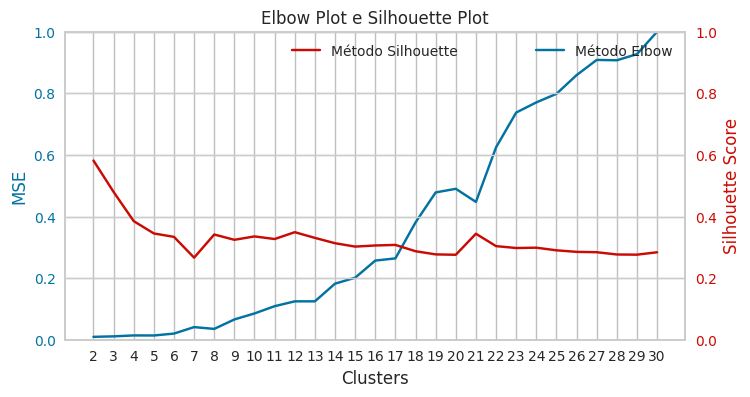

In [19]:
df = load_iris()
X,Y = treinar_kmeans(df.data,df.target)

### K-means - Treinar novamente usando o Dataset Original e o Dataset com a nova Feature

In [20]:
x_iris, y_iris, x_iris_new = criar_feature(X,Y, K=3)

AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'

### SVM - Treinar e apresentar métricas de desempenho com ambos Datasets

In [ ]:
model1, y_test1, y_pred1, model2, y_test2,y_pred2 = treinar_svm(x_iris, x_iris_new, y_iris)

In [ ]:
y_test1, y_pred1, y_test2, y_pred2 = plotar_metricas(model1, y_test1, y_pred1, model2, y_test2,y_pred2)

Melhores Parâmetros: Df Orig:  {'C': 1, 'kernel': 'linear'}  Novo: {'C': 1, 'kernel': 'linear'}
Melhores Score: Df Orig: 97% | Novo:97%
F1-score:       Df Orig:91% | Novo:91%
Acurácia:       Df Orig:91% | Novo:91%
Precisão:       Df Orig:94% | Novo:94%
Recall:         Df Orig:90% | Novo:90%
Especificidade: Df Orig:95% | Novo:95%
AUC:            Df Orig:93% | Novo:93%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

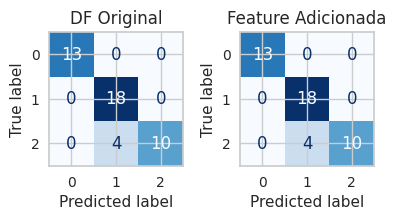

In [ ]:
plotar_matriz(y_test1,y_test2,y_pred1,y_pred2,W=4,H=4)

In [ ]:
    cm1 = metrics.confusion_matrix(y_test1, y_pred1)

    vp1 = np.diag(cm1).sum() #ok
    fp1 = cm1.sum(axis=0).sum() - vp1 #
    fn1 = cm1.sum(axis=1).sum() - vp1
    vn1 = cm1.sum() - vp1 - fp1 - fn1

    specificity = vn1 / (vn1 + fp1)

    print('vp ',vp1)
    print('fp ',fp1)
    print('vn ',vn1)
    print('fn ',fn1)
    print(specificity)


vp  41
fp  4
vn  -4
fn  4
-inf


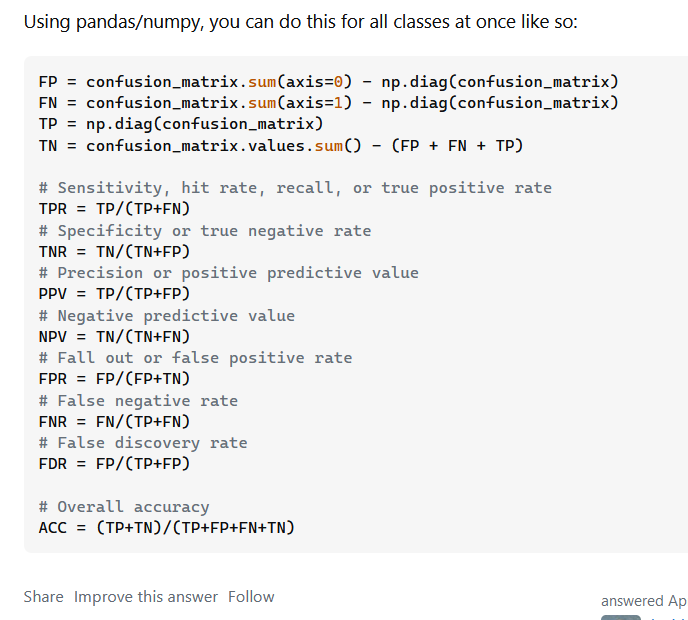

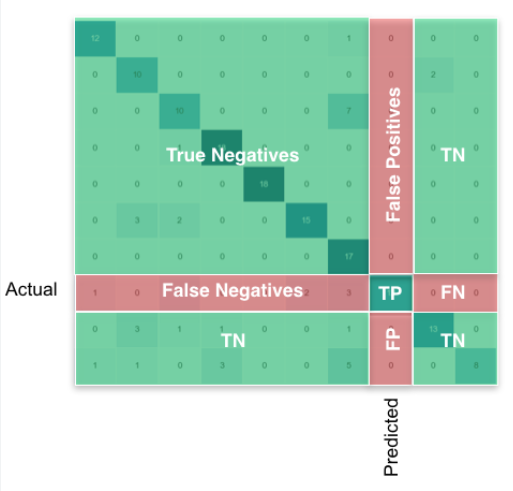

### Achei que os resultados estavam indicando Over-fit, então plotei treinei novamente com os melhores parâmetros mas iterando o valor de C para analisar as curvas de treino e teste.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

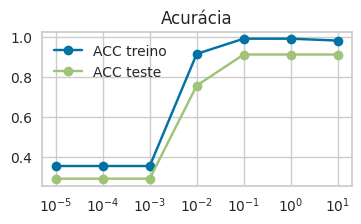

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(x_iris, y_iris, test_size=0.3, random_state=20)

C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
acc_train, acc_test = [],[]

for i in C:
    model = SVC(C=i, kernel='linear')
    model.fit(x_train, y_train)

    #Avaliar score com dados de treino
    train_pred = model.predict(x_train)
    acc_train.append(accuracy_score(y_train, train_pred))

    #Avaliar score com dados de teste
    test_pred = model.predict(x_test)
    acc_test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(4,2))
plt.title('Acurácia')
plt.semilogx(C, acc_train, '-o', label='ACC treino')
plt.semilogx(C, acc_test, '-o', label='ACC teste')
plt.legend()

### Random Tree - Treinar modelo

# **DATASET DIGITS**

In [ ]:
#Descoberta do Melhor K para criação da Feature baseada na distância dos Clusters
print('RESULTADO DATASET DIGITS')
treinar_kmeans(load_digits)

RESULTADO DATASET DIGITS


TypeError: treinar_kmeans() missing 1 required positional argument: 'Y'

In [ ]:
#Treinando modelo novamente com o melhor K
x_dig,y_dig, x_dig_new = criar_feature(load_digits, k=13)

In [ ]:
#Apresentando os resultados
y_test1, y_pred1, y_test2, y_pred2 = treinar_svm(x_dig, x_dig_new, y_dig)

In [ ]:
#Apresentando Matriz de Confusão
matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W=6,H=6)

# **DATASET WINE**

In [ ]:
#Descoberta do Melhor K para criação da Feature baseada na distância dos Clusters
print('RESULTADO DATASET WINE')
treinar_kmeans(load_wine)

In [ ]:
#Treinando modelo novamente com o melhor K
x_wine,y_wine, x_wine_new = criar_feature(load_wine, k=3)

In [ ]:
#Apresentando os resultados
y_test1, y_pred1, y_test2, y_pred2 = treinar_svm(x_wine, x_wine_new, y_wine)

In [ ]:
#Apresentando Matriz de Confusão
matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W=4,H=4)

# **DATAST BREAST CANCER**

In [ ]:
#Descoberta do Melhor K para criação da Feature baseada na distância dos Clusters
print('RESULTADO DATASET BREAST CANCER')
treinar_kmeans(load_breast_cancer)

In [ ]:
#Treinando modelo novamente com o melhor K
x_cancer,y_cancer, x_cancer_new = criar_feature(load_breast_cancer, k=2)

In [ ]:
#Apresentando os resultados
y_test1, y_pred1, y_test2, y_pred2 = treinar_svm(x_cancer, x_cancer_new, y_cancer)

In [ ]:
#Apresentando Matriz de Confusão
matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W=4,H=4)

## 5.Análise Comparativa: Será realizada uma análise comparativa para avaliar o impacto da adição das features de clusterização no desempenho dos modelos de ML. Além disso, será discutida a influência do número de clusters e das configurações do ML nas métricas de desempenho. Use gráficos para ilustrar seus argumentos.